In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [8]:
df = pd.read_csv("/content/wine-reviews.csv", usecols=['country', 'description', 'price', 'points', 'variety', 'winery'])

In [9]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [10]:
df = df.dropna(subset=['description' ,'points'])

In [11]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


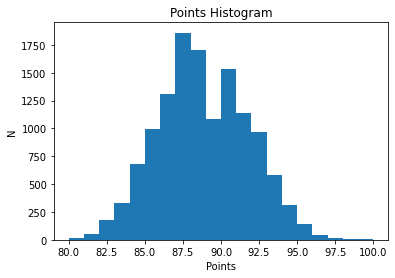

In [12]:
plt.hist(df.points, bins = 20)
plt.title("Points Histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [13]:
df["label"]=(df.points >= 90).astype(int)
df = df[["description",  "label"]]

In [15]:
df.tail()

,description,label
12944,"The Côte du Py, one of the best cru vineyard s...",1
12945,Be grateful that Stéphane Aviron is an old-vin...,1
12946,As the Stolpman family's top-of-the-line bottl...,1
12947,Hailing from a precipitously perched vineyard ...,1
12948,"The tanginess of grapefruit peel, paired with ...",1


In [17]:
train , val , test = np.split(df.sample(frac =1),[int(0.8*len(df)), int(0.9*len(df))])

In [18]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [19]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [21]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b"Scents of purple fruits and wood smoke lead into a straightforward, fruity wine that plays out broadly across the palate. Despite its forward nature, it thins out quickly. There's a bit of chocolate (from aging in 25% new French oak) in the finish.",
        b"Chardonnay has not been Silverado's strong suit in recent years and the tight, lean 2008 does not alter that conclusion. The wine is dry and acidic, with citrus and apple flavors that lack charm.",
        b'Asphalt and spice aromas are herbal and gritty. This shows a moderately full body and solid structure along with plum and herbal flavors. A dry, peppery finish is slightly rubbery in feel but fresh.',
        ...,
        b'Aromas of prune, blackcurrant, toast and oak carry through to the extracted palate, along with flavors of black cherry and roasted coffee beans. Firm but drying tannins provide the framework.',
        b"This is a suave and supple wine, with a luxu

#Embedding +Model

In [43]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable= True)

In [44]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.27910212, -0.04359968,  0.05466626, ..., -0.06932069,
        -0.15590492,  0.07646146],
       [ 0.5624335 ,  0.04498443,  0.21150261, ..., -0.12223295,
        -0.6039694 , -0.13384227],
       [ 0.2599178 , -0.01310104, -0.06107071, ..., -0.10019817,
         0.05974077, -0.01436888],
       ...,
       [ 0.42897388, -0.24239428,  0.05772968, ..., -0.05860638,
        -0.28745323,  0.11137951],
       [ 0.36357442, -0.4221188 ,  0.02540453, ...,  0.0034158 ,
        -0.15826358,  0.21268986],
       [ 0.3813432 , -0.10667308,  0.20022836, ..., -0.2466855 ,
         0.03381809,  0.22523385]], dtype=float32)>

In [56]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(20, activation ='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(20, activation ='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))

In [57]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [58]:
model.evaluate(train_data)

11/11 [==============================] - 3s 259ms/step - loss: 0.7280 - accuracy: 0.3694


[0.7280225157737732, 0.36943721771240234]

In [59]:
model.evaluate(valid_data)

2/2 [==============================] - 1s 253ms/step - loss: 0.7315 - accuracy: 0.3668


[0.7314755916595459, 0.3667953610420227]

In [53]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
11/11 [==============================] - 20s 2s/step - loss: 0.6769 - accuracy: 0.5982 - val_loss: 0.6634 - val_accuracy: 0.6386
Epoch 2/5
11/11 [==============================] - 17s 2s/step - loss: 0.6637 - accuracy: 0.6211 - val_loss: 0.6504 - val_accuracy: 0.6386
Epoch 3/5
11/11 [==============================] - 18s 2s/step - loss: 0.6526 - accuracy: 0.6205 - val_loss: 0.6394 - val_accuracy: 0.6386
Epoch 4/5
11/11 [==============================] - 19s 2s/step - loss: 0.6371 - accuracy: 0.6273 - val_loss: 0.6256 - val_accuracy: 0.6386
Epoch 5/5
11/11 [==============================] - 18s 2s/step - loss: 0.6207 - accuracy: 0.6291 - val_loss: 0.6058 - val_accuracy: 0.6386


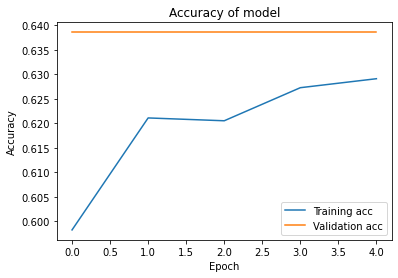

In [54]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

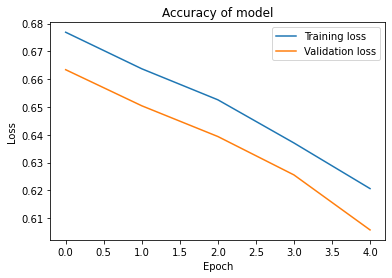

In [55]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title("Accuracy of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [60]:
model.evaluate(test_data)

2/2 [==============================] - 1s 334ms/step - loss: 0.7345 - accuracy: 0.3544


[0.7344726324081421, 0.3544401526451111]

#LSTM


In [61]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label:text))

In [62]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'in', 'flavors', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [64]:
model=tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim= len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero =True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [65]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [66]:
model.evaluate(train_data)

11/11 [==============================] - 5s 179ms/step - loss: 0.6932 - accuracy: 0.4800


[0.6932326555252075, 0.4799691140651703]

In [67]:
model.evaluate(valid_data)

2/2 [==============================] - 0s 62ms/step - loss: 0.6933 - accuracy: 0.4741


[0.6932790875434875, 0.4741312861442566]

In [68]:
history = model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
11/11 [==============================] - 14s 633ms/step - loss: 0.6872 - accuracy: 0.6141 - val_loss: 0.6757 - val_accuracy: 0.6386
Epoch 2/5
11/11 [==============================] - 5s 491ms/step - loss: 0.6652 - accuracy: 0.6305 - val_loss: 0.6462 - val_accuracy: 0.6386
Epoch 3/5
11/11 [==============================] - 5s 494ms/step - loss: 0.6446 - accuracy: 0.6305 - val_loss: 0.6272 - val_accuracy: 0.6386
Epoch 4/5
11/11 [==============================] - 7s 630ms/step - loss: 0.6147 - accuracy: 0.6317 - val_loss: 0.5798 - val_accuracy: 0.6579
Epoch 5/5
11/11 [==============================] - 5s 462ms/step - loss: 0.5433 - accuracy: 0.7033 - val_loss: 0.5113 - val_accuracy: 0.7606


In [69]:
model.evaluate(test_data)

2/2 [==============================] - 1s 119ms/step - loss: 0.5069 - accuracy: 0.7653


[0.5068821310997009, 0.7652509808540344]